# 02 - EDA Structural and Graph Metrics

## Purpose

This notebook will analyze:
- Distributions of note metrics
- Relationship between structural and graph metrics

### Set up

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
sns.set(style="whitegrid")

In [2]:
# load total df and start analysis, begining with structural match.
df=pd.read_csv("../0-coarse-preprocess/note_full_metrics.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 872 entries, 0 to 871
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   note_id                  872 non-null    object
 1   title                    872 non-null    object
 2   word_count               872 non-null    int64 
 3   line_count               872 non-null    int64 
 4   section_count            872 non-null    int64 
 5   max_heading_depth        872 non-null    int64 
 6   list_item_count          872 non-null    int64 
 7   code_block_count         872 non-null    int64 
 8   code_block_line_count    872 non-null    int64 
 9   image_count              872 non-null    int64 
 10  table_count              872 non-null    int64 
 11  quote_block_count        872 non-null    int64 
 12  frontmatter_present      872 non-null    bool  
 13  frontmatter_field_count  872 non-null    int64 
 14  tag_count                872 non-null    i

In [4]:
# Exclude 'title' and 'note_id' from analysis
exclude_cols = ['title', 'note_id']

# Separate numeric and categorical columns automatically, excluding specified columns
numeric_cols = [col for col in df.select_dtypes(include='number').columns if col not in exclude_cols]
categorical_cols = [col for col in df.select_dtypes(include=['object', 'bool', 'category']).columns if col not in exclude_cols]

# Get top 5 rows per numeric metric
top_5_per_numeric = {col: df[['note_id', col]].nlargest(5, col) for col in numeric_cols}

# Get value counts for categorical columns
categorical_counts = {col: df[col].value_counts(dropna=False).reset_index(name='count') for col in categorical_cols}

top_5_per_numeric['word_count']

,note_id,word_count
276,excel_&_sheets,2050
648,pytorch,1569
410,interview_notepad,1273
799,transformers_vs_rnns,1180
820,use_of_rnns_in_energy_sector,1148


In [5]:
G = nx.read_gexf("../0-coarse-preprocess/note_graph.gexf")

# show subgraph of G with Nodes from a given list
def show_subgraph(G, nodes):
    subgraph = G.subgraph(nodes)
    return subgraph

# # Plot graph
# nodes=['acid_transaction','transaction','sqlite']
# subgraph = show_subgraph(G, nodes)
# nx.draw(subgraph, with_labels=True)

## Note Corpus Analysis

### 1. Content Density and Structural Complexity

We aim to analyze correlations between the following note metrics to understand how structural complexity evolves with note length:

- `word_count`
- `line_count`
- `section_count`
- `max_heading_depth`

*Note:* A note is considered “complete” if it contains frontmatter (i.e., `has_frontmatter=True`).

**Exploratory Questions and Answers:**

- **Q:** Are longer notes more sectionalized (i.e., do they have a higher `section_count`)?  
  **A:** The metrics `line_count`, `word_count`, and `section_count` are approximately correlated. Therefore, we focus primarily on `word_count` as the main measure of note length.

- **Q:** How many notes are considered long by `word_count`?  
  **A:** Out of 479 complete notes, 35 have a `word_count` greater than 500.

- **Q:** Which notes have the highest `word_count`?  
  **A:** The top five notes by word count are:  
  - Excel & Sheets  
  - PyTorch  
  - Interview Notepad  
  - Transformers vs RNNs  
  - Use of RNNs in the Energy Sector

- **Q:** What does the distribution of shorter notes look like?  
  **A:** A histogram of notes with fewer than 500 words shows their distribution and potential breakpoints.

- **Q:** Does `max_heading_depth` increase with `word_count`?  
  **A:** Not significantly. Due to inconsistent use of heading levels (sometimes level 2, sometimes level 6), there is no strong correlation. Thus, longer notes do not necessarily have deeper heading hierarchies.

#### 1. Implementation Notes

**Approach:**

- Filter the dataset to include only complete notes.
- Plot histograms of `word_count` and `line_count` to identify natural breakpoints, such as distinguishing between short, medium, and long notes.
- Use pairplots or heatmaps to visualize correlations among the four core complexity metrics.

In [23]:
# Filter dataframe for complete notes (with frontmatter)
df_complete = df[df['has_frontmatter'] == True]
df_complete.shape
# df_complete=df

(479, 27)

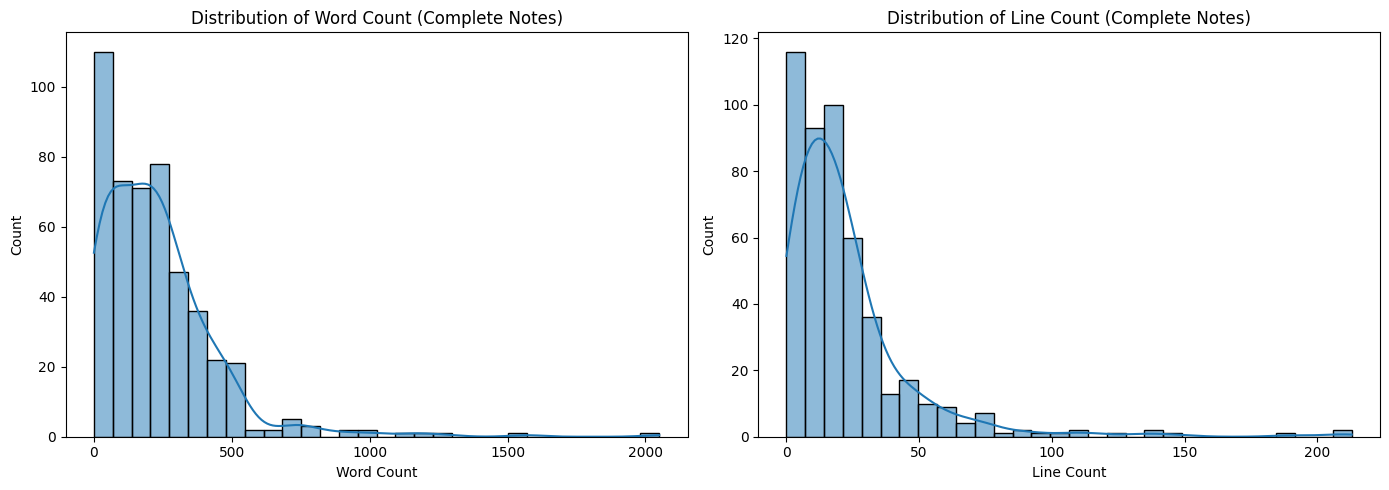

In [24]:
# Plot histograms of word_count and line_count to find natural breakpoints
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df_complete['word_count'], bins=30, ax=axes[0], kde=True)
axes[0].set_title('Distribution of Word Count (Complete Notes)')
axes[0].set_xlabel('Word Count')

sns.histplot(df_complete['line_count'], bins=30, ax=axes[1], kde=True)
axes[1].set_title('Distribution of Line Count (Complete Notes)')
axes[1].set_xlabel('Line Count')

plt.tight_layout()
plt.show()

In [41]:
# get a breakdown of the dsitrbution of word count. 
df_complete['word_count'].describe()
#show as a boxplot
df_complete_reduced = df_complete[df_complete['word_count'] < 500]
df_complete_reduced_500 = df_complete[df_complete['word_count'] > 500]

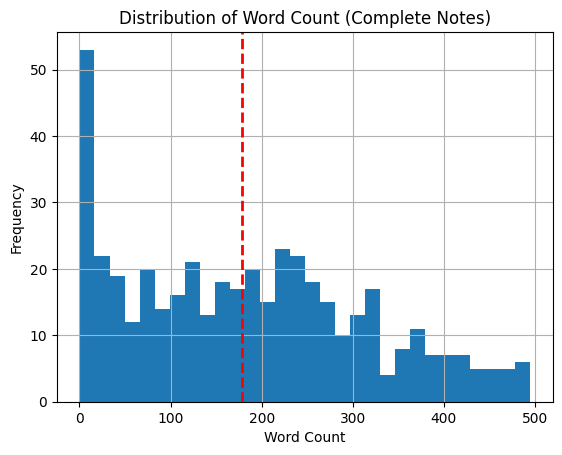

In [42]:
#horizontal boxplot
df_complete_reduced['word_count'].describe()
# df_complete_reduced['word_count'].plot(kind='box')

# plot as a histogram with median line
df_complete_reduced['word_count'].hist(bins=30)
plt.axvline(df_complete_reduced['word_count'].median(), color='r', linestyle='dashed', linewidth=2)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Count (Complete Notes)')
plt.show()

In [43]:
df_complete_reduced_500.shape
#order by word count
df_complete_reduced_500 = df_complete_reduced_500.sort_values(by='word_count', ascending=False)
# df_complete_reduced_500.head()
# for title in df_complete_reduced_500['title'][0:5]:
#     print(title)

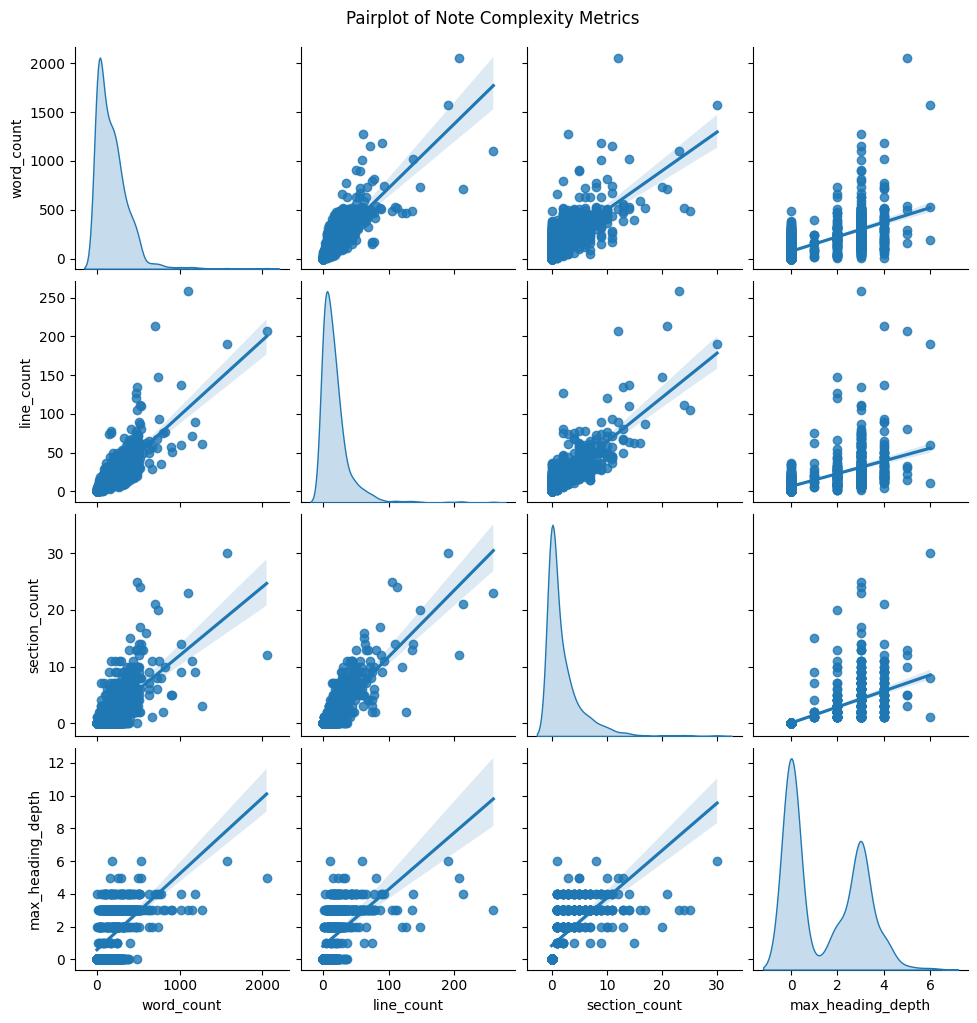

In [19]:
# Pairplot and correlation heatmap to visualize relationships among metrics
metrics = ['word_count', 'line_count', 'section_count', 'max_heading_depth']

# Pairplot with regression lines
sns.pairplot(df_complete[metrics], kind='reg', diag_kind='kde')
plt.suptitle('Pairplot of Note Complexity Metrics', y=1.02)
plt.show()

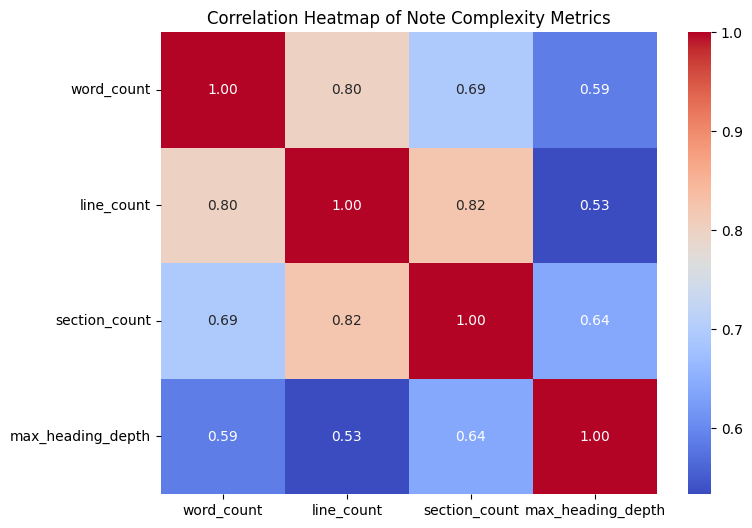

In [20]:
# Correlation heatmap
corr = df_complete[metrics].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Note Complexity Metrics')
plt.show()

### 2. Tagging Strategy and Metadata Standards

This section explores how tagging behavior and metadata completeness relate to the structural characteristics of notes. While we currently do **not** have access to the tag contents themselves, we rely on the following proxy metrics:

* `tag_count`: The number of tags associated with a note (tag strings not yet available).
* `frontmatter_present`: Boolean indicating whether frontmatter is present.
* `frontmatter_field_count`: Count of fields in the frontmatter block.

*Note:* A note is considered “complete” if `frontmatter_present=True`.

**Exploratory Questions and Future Directions:**

* **Q:** How many notes do (not) have frontmatter (`frontmatter_present=True`).
  **A:** *(To be analyzed)*

* **Q:** My style of note taking has changed, where I use a template for new notes. Consider the distrubution of `frontmatter_field_count` and confirm this

* **Q:** Is higher `tag_count` values associated with longer notes? What is the distribution of `tag_count` across the corpus? I expect there it to center around 3 tags per note. Inspect the tails of the distribution. * Is `total_degree` corrolated notes with more tags?

### Further Questions (for future work with full tag data)

These questions require access to tag-level details and will be explored once tag strings are available.

* **Q:** What is the distribution and frequency of unique tags across the corpus?
* **Q:** Do specific tags co-occur frequently, and can we construct a tag co-occurrence graph?
* **Q:** Can we detect thematic tag clusters or redundant tags requiring consolidation?
* **Q:** How well do tags align with inferred topics or semantic embeddings of note content? Are the tags relevant to the content? Compare inferred taxonomy to defined taxomony.


#### 2. Implementation Notes

**Approach:**

* Analyze the distribution of `tag_count` to understand general annotation density across notes.
* Compare `word_count` across `tag_count` bins to assess whether more detailed notes are also more heavily tagged.

**Suggested Visual Analyses:**

* Histogram of `tag_count` to inspect tagging intensity across the dataset.
* Boxplots of `word_count` across `tag_count` bins (e.g., 0, 1–2, 3–5, >5).
* Bar plots of `frontmatter_field_count` with `frontmatter_present`=True.

## **1. Overview of Frontmatter Presence**

### Summary Table: Word Count Statistics by Frontmatter

| **Metric** | **With Frontmatter** | **Without Frontmatter** | **Interpretation**                                                                                              |
| ---------- | -------------------- | ----------------------- | --------------------------------------------------------------------------------------------------------------- |
| Count      | 479                  | 393                     | Fairly even split between the two groups.                                                                       |
| Mean       | 227               | 128               | Notes with frontmatter are, on average, \~77% longer.                                                           |
| Std Dev    | 218               | 152                  | Greater variability in the structured notes.                                                                    |
| Min        | 0                | 0                    | Both categories contain empty notes.                                                                            |
| 25%        | 73                | 6                    | A quarter of frontmatter notes have at least 73 words; many non-frontmatter notes are near empty.               |
| Median     | 192            | 73                   | Median word count for frontmatter notes is approximately 2.6x higher.                                           |
| 75%        | 310              | 204                  | The upper quartile of frontmatter notes is longer, though closer in range to structured notes at the upper end. |
| Max        | 2050              | 1099                 | The longest frontmatter note is nearly twice as long as the longest without.                                    |

### Interpretation and Implications

* **Quality Gap**:
  The lower quartile (`25%`) for non-frontmatter notes is extremely low, suggesting that a substantial portion of these are **underdeveloped or unfinished**.

* **Notes without frontmatter** are likely:

  * Initial rough captures.
  * Auto-generated or placeholder stubs.
  * Notes that have not yet been revised or upgraded to your current structured template.

### Suggested Actions

* Consider **cleaning or archiving notes with `word_count < 20` and no frontmatter**.
* Investigate **high-word-count notes without frontmatter** — these may be **legacy notes** that are detailed but unstructured. Revisit and **retrofit them with frontmatter** to bring them in line with your current standards.

In [ ]:
# Count of notes with and without frontmatter
print("Frontmatter Presence:")
# --- 2. WORD COUNT STATISTICS TABLE ---

# Separate notes by frontmatter presence
df_fm = df[df['frontmatter_present']]
df_no_fm = df[~df['frontmatter_present']]

# Get descriptive stats
fm_stats = df_fm['word_count'].describe()
no_fm_stats = df_no_fm['word_count'].describe()

# Combine into a summary table
summary_table = pd.DataFrame({
    "With Frontmatter": fm_stats,
    "Without Frontmatter": no_fm_stats
})

# Round for readability
summary_table = summary_table.round(2)

print("\nWord Count Statistics by Frontmatter Presence:\n")
print(summary_table)

print("\n Top notes by word count with no frontmatter")
df_no_fm[['note_id', 'title', 'word_count']].sort_values(by='word_count', ascending=False).head(5)


Frontmatter Presence:

Word Count Statistics by Frontmatter Presence:

       With Frontmatter  Without Frontmatter
count            479.00               393.00
mean             227.02               128.22
std              218.19               152.35
min                0.00                 0.00
25%               73.00                 6.00
50%              192.00                73.00
75%              310.50               204.00
max             2050.00              1099.00

 Top notes by word count with no frontmatter


,note_id,title,word_count
290,fastapi_example.py,FastAPI_Example.py,1099
596,pdoc,pdoc,664
636,pydantic,Pydantic,633
306,fitting_weights_and_biases_of_a_neural_network,Fitting weights and biases of a neural network,632
850,why_does_label_encoding_give_different_predict...,Why does label encoding give different predict...,631


--- 4. TAG COUNT DISTRIBUTION ---


Out of approximately 480 notes with frontmatter, only 8 notes have more than 3 tags, indicating that tagging is relatively sparse across the collection. The majority of notes use between 1 and 3 tags, aligning with a common practice of maintaining focus and simplicity in note categorization.

However, a significant number of notes have 0 or 1 tags, which may limit their discoverability and integration within the broader network of notes. It would be beneficial to target a baseline of around 3 tags per note, where appropriate, to improve semantic richness and retrieval.

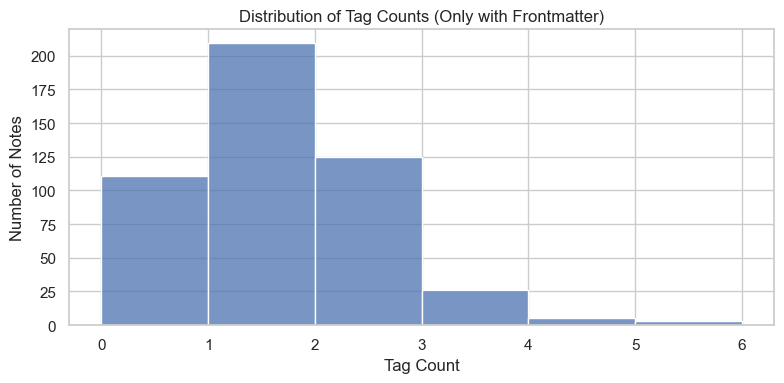

Notes with more than 3 tags: 8
                                   title  tag_count
674                       Regularisation          6
172       Data Pipeline to Data Products          5
618                        Preprocessing          5
37                      Asking questions          4
600                    Performance Drift          4
471                                 LSTM          4
673  Regularisation of Tree based models          4
820         Use of RNNs in energy sector          4


In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(df_fm['tag_count'], bins=range(0, df_fm['tag_count'].max() + 1), kde=False)
plt.title("Distribution of Tag Counts (Only with Frontmatter)")
plt.xlabel("Tag Count")
plt.ylabel("Number of Notes")
plt.tight_layout()
plt.show()

# Print extreme values
tag_counter=3
print(f"Notes with more than {tag_counter} tags: {len(df_fm[df_fm['tag_count'] > tag_counter])}")
print(df_fm[df_fm['tag_count'] > tag_counter][['title', 'tag_count']].sort_values(by='tag_count', ascending=False).head(10))

--- 5. BIN TAG COUNTS AND COMPARE WORD COUNT ---

5. Tag Count Bins and Word Count Comparison:

Here is a structured analysis of your `word_count` summary statistics grouped by `tag_bin` (`0`, `1`, `2`, `3`, `4+`), focusing on how note length relates to tagging behavior:

Key Observations:

1. **Length increases with tags up to a point**:
   There is a **general upward trend** in `mean` and `median` word count from tag bins `0 → 2`, suggesting that more heavily tagged notes tend to be more developed and content-rich.

2. **Highly tagged notes are rare but long**:
   Notes with `4+` tags are **uncommon** (only 8), but they have the **highest average word count** (514) and the **widest range**, suggesting they may be comprehensive or reference-style notes.

3. **Low-tag notes are shorter and noisier**:
   The `0` tag bin has a relatively low median (130), and includes many very short notes (25% have fewer than 18 words), likely reflecting incomplete or placeholder notes.

4. **Bin 3 is anomalous**:
   Compared to bin `2`, bin `3` shows a **lower median and mean**, despite a higher tag count. This is likely due to **small sample size (n=26)** and might not be representative.

Interpretation:

* These results support the hypothesis that **tagging correlates with note completeness**: more tags generally appear in longer, richer notes.
* However, the relationship is **not perfectly linear**, especially due to small sample sizes in the upper bins.


C:\Users\RhysL\AppData\Local\Temp\ipykernel_14380\306850789.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_fm, x='tag_bin', y='word_count', order=bin_order, palette="pastel")


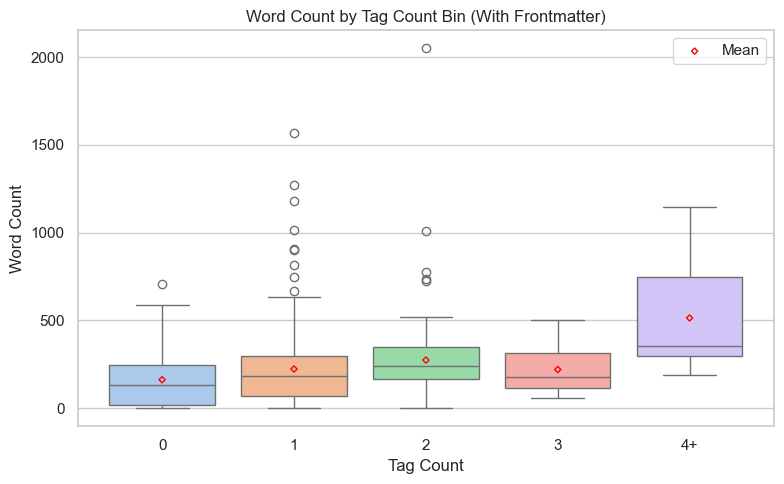

In [53]:
# Ensure working on a copy to avoid SettingWithCopyWarning
df_fm = df_fm.copy()

# Define explicit tag bins
def tag_bin_explicit(x):
    if x == 0:
        return "0"
    elif x == 1:
        return "1"
    elif x == 2:
        return "2"
    elif x == 3:
        return "3"
    else:
        return "4+"

# Apply binning safely
df_fm.loc[:, 'tag_bin'] = df_fm['tag_count'].apply(tag_bin_explicit)

# Define correct plot order
bin_order = ['0', '1', '2', '3', '4+']

# Compute mean word count for each bin
mean_word_counts = df_fm.groupby('tag_bin')['word_count'].mean().reindex(bin_order)

# Plot boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_fm, x='tag_bin', y='word_count', order=bin_order, palette="pastel")

# Overlay mean values: diamond shape, hollow (no fill), red edge
plt.scatter(
    x=range(len(bin_order)),
    y=mean_word_counts,
    marker='D',
    facecolors='none',
    edgecolors='red',
    s=10,
    label='Mean',
    zorder=10
)

# Add legend and labels
plt.legend()
plt.title("Word Count by Tag Count Bin (With Frontmatter)")
plt.xlabel("Tag Count")
plt.ylabel("Word Count")
plt.tight_layout()
plt.show()


In [ ]:
# Compute descriptive statistics by tag_bin
summary_table = df_fm.groupby('tag_bin')['word_count'].describe().loc[bin_order]

# Display table rounded for readability
print(summary_table.round(0))

         count   mean    std    min    25%    50%    75%     max
tag_bin                                                         
0        110.0  160.0  160.0    0.0   20.0  130.0  250.0   710.0
1        210.0  220.0  230.0    0.0   70.0  180.0  300.0  1570.0
2        120.0  270.0  230.0    0.0  160.0  240.0  350.0  2050.0
3         30.0  220.0  130.0   60.0  110.0  180.0  320.0   500.0
4+        10.0  510.0  340.0  190.0  300.0  350.0  740.0  1150.0


--- 6. CORRELATION: TAG COUNT VS TOTAL DEGREE ---

Comment: Spearman correlation is preferred here because both tag_count and total_degree are discrete, non-normally distributed variables with potential outliers and a likely monotonic but non-linear relationship.




C:\Users\RhysL\AppData\Local\Temp\ipykernel_14380\391747754.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


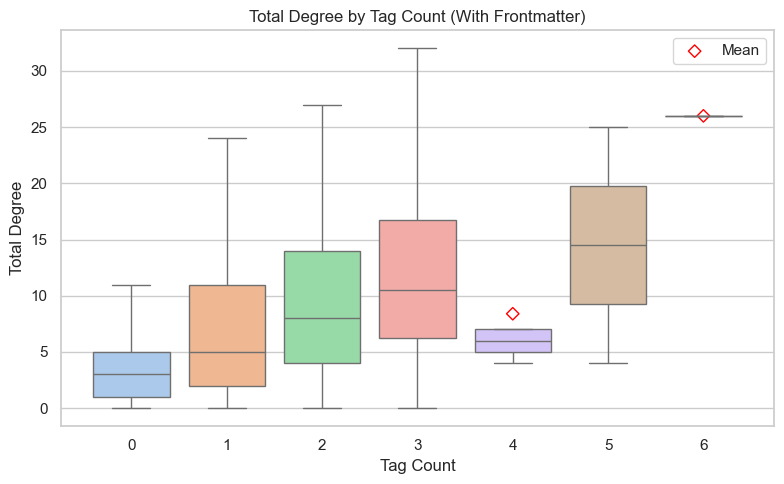

In [61]:
plt.figure(figsize=(8, 5))

# Create boxplot with outliers hidden (showfliers=False)
sns.boxplot(
    data=df_fm,
    x='tag_count',
    y='total_degree',
    showfliers=False,         # Hide individual outlier points
    palette='pastel'
)

# Compute means for each tag_count group
means = df_fm.groupby('tag_count')['total_degree'].mean()

# Overlay diamond-shaped markers for the means
plt.scatter(
    x=means.index,
    y=means.values,
    marker='D',
    facecolors='none',
    edgecolors='red',
    s=40,
    label='Mean'
)

# Add labels and legend
plt.title("Total Degree by Tag Count (With Frontmatter)")
plt.xlabel("Tag Count")
plt.ylabel("Total Degree")
plt.legend()
plt.tight_layout()
plt.show()


In [62]:
spearman_corr = df_fm[['tag_count', 'total_degree']].corr(method='spearman').iloc[0, 1]
print(spearman_corr)
# comment for why spearman is better than pearson in this case
# Spearman correlation: 0.383

0.38262911548627926


### 3. Formatting and Rich Media Usage

This section explores how notes use formatting features and rich media such as images, code blocks, tables, quotes, and lists. These features are considered structural signals of note intent, style, or technical depth.

Key metrics under consideration:

* `image_count` (including both Markdown and Obsidian-style embeds)
* `table_count`, `has_table`
* `code_block_count`, `code_block_line_count`, `has_code`
* `has_quotes`, `has_lists`

*Note:* Detection has been extended to support both `![](...)` and Obsidian-style `![[...]]` image embeds.

**Exploratory Questions and Future Directions:**

* **Q:** Are notes with images/tables/code blocks generally longer? (boxplots)
  **A:** *(To be analyzed)*

* **Q:** Which titles of notes are more likely to contain rich media usage?
  **A:** *(To be analyzed)*

* **Q:** How does `code_block_count` & `table_count` vary with note `word_count` ?
  **A:** *(To be analyzed)*

* **Q:** Does heavy formatting signal more external utility (e.g., notes for a hub within the graph)?
  **A:** *(To be analyzed)*


#### 3. Implementation Notes

**Approach:**

* Compute usage frequencies of each format type (`image`, `table`, `code`, `quote`, `list`) across all notes.
* Compare `word_count` and `section_count` across notes with and without these formatting features.
* Use cross-tabulations to identify overlaps (e.g., notes that include both code and tables).
* Analyze how rich media features relate to the structural complexity and potential purpose of notes (e.g., scratchpad vs. documentation).
* Look at the title names of notes with rich media to identify patterns in  usage

**Suggested Visual Analyses:**

* Histogram of `image_count`, `table_count`, `code_block_count`, and `code_block_line_count`.
* Bar chart: notes with vs. without images, stratified by `word_count` bins.
* Cross-tabulation of `has_table` × `has_code` to find overlaps in data + code-rich notes.
* Bar plots of `has_quotes` and `has_lists`, annotated with median `word_count`.
* Word clouds of high-list and high-quote notes (optional, if textual content is available).


### 4. Note Hygiene and Maintenance

This section investigates the structural quality of notes by identifying empty and underdeveloped entries and analyzing how well these notes are integrated into the broader network. The focus is on identifying notes that lack content, structure, or meaningful connections to other notes.

**Core metrics:**

* `is_empty`: Boolean flag indicating structurally empty notes.
* `word_count`: Used to identify stubs or low-content notes.
* `outlink_count`, `inlink_count`, `total_degree`: Used to assess network connectivity.
* `is_orphan`: Boolean flag for notes with no incoming or outgoing links.

### Exploratory Questions and Future Directions

* **Q:** How many notes are completely empty, and are any of them connected to other notes?
  **A:** *(To be analyzed)*

* **Q:** How many notes fall below a stub threshold (e.g., `word_count < 50`)? Are these stubs linked into the network, or are they isolated?
  **A:** *(To be analyzed)*

* **Q:** Can we use thresholds on word count and graph connectivity to flag notes for cleanup?
  *For example, an isolated empty note may be a candidate for deletion, whereas a stub with some links might merit expansion or consolidation.*
  **A:** *(To be analyzed)*

* **Q:** Can we define a triage scoring system that weights content and connectivity features (e.g., `word_count`, `total_degree`) to flag notes for review?
  *Justification:* Enables rule-based prioritization of note maintenance through feature engineering.

* **Q:** Are there stubs that act as navigational anchors despite having low content (e.g., high `inlink_count`)?
  *Justification:* Some stubs may provide structural value despite their brevity. How should we assess the functional role of a stub?

* **Q:** Do hygiene issues (e.g., clusters of stubs or empty notes) appear in specific regions of the note-link graph?
  *Method:* Use component or subgraph analysis to identify localized quality gaps.

* **Q:** Are there structural bottlenecks where many low-content notes link into a single hub?
  *Justification:* Such patterns may indicate poor modularity or the need to consolidate high-traffic nodes.

#### 4. Implementation Notes

**Approach:**

* Quantify the number of empty notes and assess their positions in the graph.
* Define a rule-based stub threshold (e.g., `word_count < 50`).
* Evaluate the connectivity of stubs using `inlink_count`, `outlink_count`, and `total_degree`.
* Identify notes that are both low in content and weakly connected, marking them as hygiene risks.

**Suggested Visual Analyses:**

* Histogram of `word_count`, focused on the lower tail (<200 words), with a vertical line marking the stub threshold.
* Scatter or hexbin plots of `word_count` vs. `inlink_count` or `outlink_count`, highlighting stubs and empty notes.
* Network graph visualizations:

  * Highlight nodes with `is_empty = True` or `word_count < 50`.
  * Identify and label orphaned nodes (`is_orphan = True`).
* Summary tables showing degree statistics (`total_degree`, `inlink_count`, `outlink_count`) for empty and stub notes.



### 5. Specialized Content: Math and Technical Depth

This section focuses on the presence of mathematical notation within notes, using `has_math` as a binary indicator of LaTeX or math-block usage. While math occurs infrequently (78 notes), it may signal higher technical depth or topic-specific content (e.g., probability, statistics, machine learning).

**Core metric:**

* `has_math`: Boolean flag indicating use of mathematical notation.

### Exploratory Questions

* **Q:** Are math-heavy notes longer or more structurally complex than the average?
  **A:** *(To be analyzed)*

* **Q:** Do math-heavy notes also include more technical formatting (e.g., code blocks, tables, or images)?
  **A:** *(To be analyzed)*

* **Q:** Which content areas or tags (e.g., "ML", "probability", "statistics") are most associated with math-heavy notes?
  *Justification:* Supports targeted review of math-intensive domains.

* **Q:** Which non-math notes could benefit from the inclusion of mathematical content (e.g., notes with technical subjects but no equations)?
  *Method:* Identify notes with high code usage or structural depth but no math — potential candidates for augmentation.

#### 5. Implementation Notes

**Approach:**

* Subset the dataset to notes where `has_math = True`.
* Compute and compare average `word_count`, `section_count`, `code_block_count`, and `image_count` against non-math notes.
* Identify notes with high technical density (e.g., many code blocks, tables) but no math for targeted review.

**Suggested Visual Analyses:**

* Bar plots comparing structural metrics between math and non-math notes.
* Venn or overlap diagram of `has_math` with `has_code`, `has_table`, and `has_image`.
* Histogram of `word_count` for math-heavy notes vs. others.
